# Wine Classification with Support Vector Machine (SVM)
This notebook trains a Support Vector Machine classifier on the wine dataset, explores feature importance using coefficients, and evaluates model performance with various metrics.

In [1]:
import sys
from pathlib import Path
# Ensure project root is in the Python path for module resolution
project_root = str(Path.cwd().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler
from src.data.load_wine import get_wine_data

In [3]:
# Load the wine dataset
df_X, df_y = get_wine_data(as_frame=True)
df = df_X.copy()
df['target'] = df_y

X = df_X
y = df_y

## Train/Test Split and Scaling

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SVMs benefit from feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning with Cross-Validation

In [5]:
# Grid search for best SVM parameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validation accuracy:', grid_search.best_score_)

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9862068965517242


## Train and Evaluate the Best SVM Model

In [6]:
# Train and evaluate the best model
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)
y_pred = best_svm.predict(X_test_scaled)

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Test Accuracy: 0.9722222222222222

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



## ROC Curve and AUC

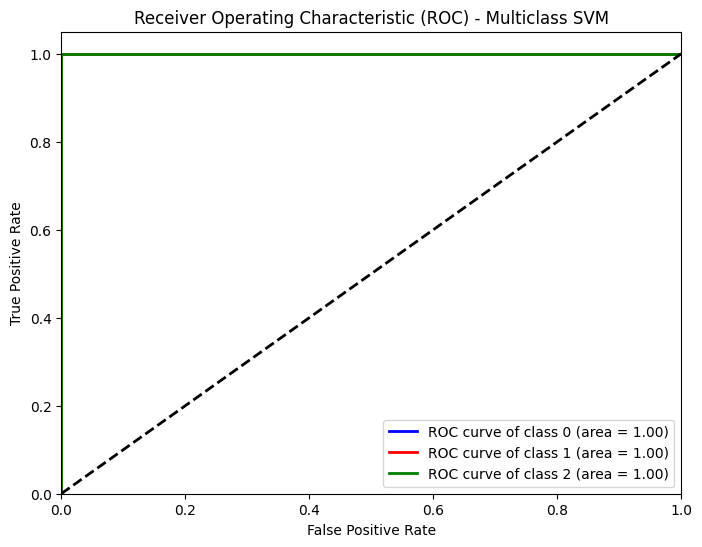

Macro-average AUC: 1.0
Weighted-average AUC: 1.0


In [7]:
# ROC curve and AUC for multiclass SVM
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = best_svm.predict_proba(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass SVM')
plt.legend(loc='lower right')
plt.show()

print('Macro-average AUC:', roc_auc_score(y_test_bin, y_score, average='macro'))
print('Weighted-average AUC:', roc_auc_score(y_test_bin, y_score, average='weighted'))

## Confusion Matrix Visualization

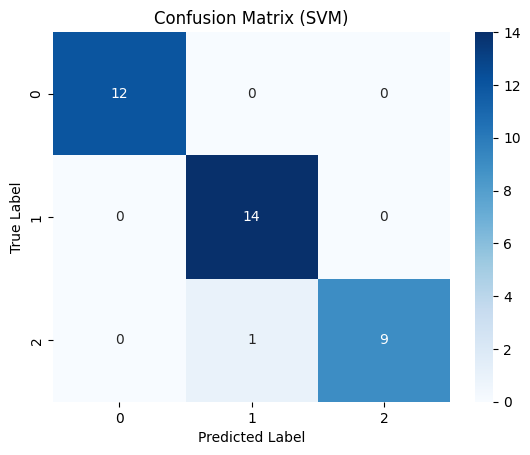

In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM)')
plt.show()

## Feature Importance (Linear SVM Only)
If the best kernel is linear, we can inspect the coefficients for feature importance.

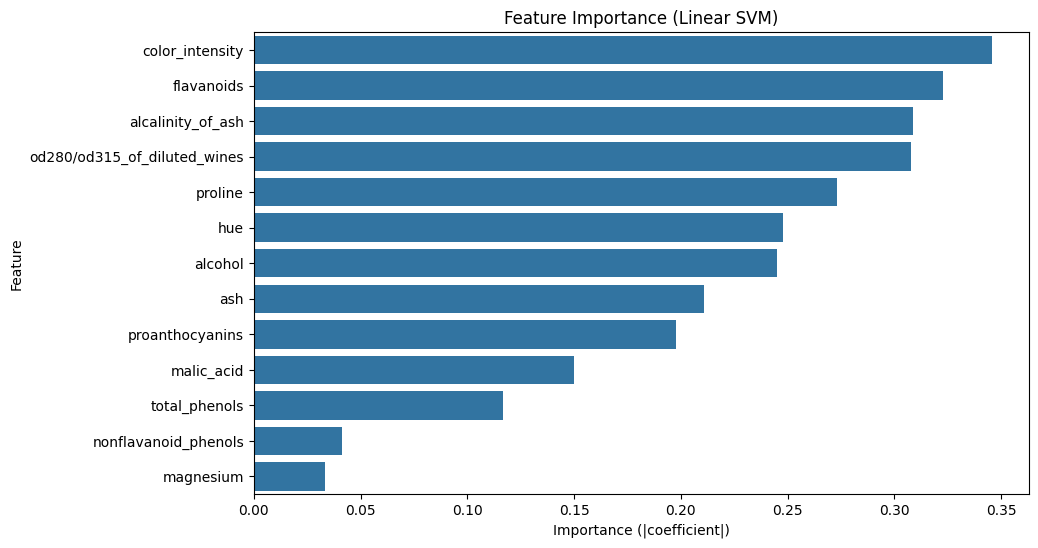

In [9]:
if grid_search.best_params_['kernel'] == 'linear':
    coefs = best_svm.coef_
    feature_importance = np.mean(np.abs(coefs), axis=0)
    sorted_idx = np.argsort(feature_importance)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance[sorted_idx], y=X.columns[sorted_idx], orient='h')
    plt.title('Feature Importance (Linear SVM)')
    plt.xlabel('Importance (|coefficient|)')
    plt.ylabel('Feature')
    plt.show()
else:
    print('Feature importance is only available for linear kernel SVMs.')